# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


**Общая информация**

**Срок сдачи:** 25 апреля 18:00 Сдача **очная** на онлайн занятии.


Используйте данный Ipython Notebook при оформлении домашнего задания.

Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0422, Задание 2] Фамилия Имя.



**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***  
Везде далее я использую $x_i$ для обозначения объектов из батча, то есть $i$ - это индекс объекта конкретно в том батче, по которому мы делаем шаг, а не номер объекта во всей выборке, для $y_i$ аналогично.  
Пусть $h$ - темп обучения,  
$$L_i(w) = (y_i - a_i) ^ 2$$ - потери на одном объекте без учета регуляризации,  
$$ grad(R(w)) =  grad(\sum_{k=1}^{D}w_k^2) = \left( \frac{\partial \sum_{k=1}^{D}w_k^2}{\partial w_j} \right)_{j=1}^{D} =  \left(2w_j\right)_{j=1}^{D} = 2w$$  
$$a_i = a(x_i, w) = \langle x_i, w \rangle$$  
$$grad(\langle x_i, w \rangle) = \left( \frac{\partial \sum_{k=1}^{D}x_{i,k} \cdot w_k}{\partial w_j} \right)_{j=1}^{D} = x_i$$  
$$grad((y_i - \langle x_i, w \rangle) ^ 2)=2(y_i - \langle x_i, w \rangle)grad(-\langle x_i, w \rangle)=-2(y_i - \langle x_i, w \rangle)x_i $$ 
тогда    


$$ w_{new}
= w_{old} - \frac{h}{n}\sum_{i=1}^{n} grad\left(L_i(w)\right) - h\frac{n}{N} \cdot \frac{1}{C} grad\left(R(w)\right)
= w_{old} - \frac{h}{n}\sum_{i=1}^{n} grad((y_i - \langle x_i, w \rangle) ^ 2) - \frac{nh}{CN} \cdot grad(R(w))
= w_{old} + \frac{2h}{n} \cdot \sum_{i=1}^{n} (y_i - \langle x_i, w_{old} \rangle) x_i - \frac{2nh}{NC}w_{old} = (1 - \frac{2h}{NC}) w_{old} + \frac{h}{n} \cdot \sum_{i=1}^{n} 2(y_i - \langle x_i, w_{old} \rangle) x_i =\newline
= (1 - \frac{2hn}{NC}) w_{old} + \frac{2h}{n} \cdot \sum_{i=1}^{n} (y_i - a(x_i)) x_i$$
  
  

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***  
$$L_i(w) = - \left[y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right]$$ - потери на одном объекте без учета регуляризации,  
$$a_i = a(x_i) =  \sigma( \langle\,x_i,w\rangle )$$  
$$\frac{d\sigma(x)}{dx} = \frac{d(1 + e^{-x})^{-1}}{dx} = (-1) \cdot (1 + e^{-x})^{-2}\frac{de^{-x}}{dx} = (-1) \cdot (1 + e^{-x})^{-2}e^{-x}\cdot (-1) = \frac{e^{-x}}{(1 + e^{-x})^{2}} = \frac{1}{1 + e^{-x}} \cdot \frac{e^{-x}}{1 + e^{-x}} = \frac{1}{1 + e^{-x}} \cdot \frac{e^{-x}+1-1}{1 + e^{-x}} = \frac{1}{1 + e^{-x}} \cdot (1-\frac{1}{1 + e^{-x}}) = \sigma(x)(1-\sigma(x))$$
  
тогда  
$$ w_{new}
= w_{old} - \frac{h}{n}\sum_{i=1}^{n} grad(L_i(w)) + \frac{n}{N}\frac{1}{C} \cdot grad(R(w))
= \{  аналогично\, предыдущему\, пункту \}
= (1 - \frac{2nh}{NC}) w_{old} - \frac{h}{n}\sum_{i=1}^{n} grad(L_i(w)) 
= (1 - \frac{2nh}{NC}) w_{old} + \frac{h}{n}\sum_{i=1}^{n}  \left( \frac{\partial y_i \log a_i + ( 1 - y_i) \log (1 - a_i)}{\partial w_j} \right)_{j=1}^{D}
= (1 - \frac{2nh}{NC}) w_{old} + \frac{h}{n}\sum_{i=1}^{n}  \left( \frac{y_i}{a_i} \frac{\partial a_i}{\partial w_j} + \frac{1-y_i}{1-a_i}\frac{\partial (-a_i)}{\partial w_j} \right)_{j=1}^{D}
= (1 - \frac{2nh}{NC}) w_{old} + \frac{h}{n}\sum_{i=1}^{n}  \left( \frac{y_i}{\sigma( \langle\,x_i,w\rangle )} \frac{\partial \sigma( \langle\,x_i,w\rangle )}{\partial w_j} + \frac{1-y_i}{1-\sigma( \langle\,x_i,w\rangle )}\frac{\partial (-\sigma( \langle\,x_i,w\rangle ))}{\partial w_j} \right)_{j=1}^{D}
= (1 - \frac{2nh}{NC}) w_{old} + \frac{h}{n}\sum_{i=1}^{n}  \left[ \frac{y_i}{\sigma( \langle\,x_i,w_{old}\rangle )} \sigma( \langle\,x_i,w_{old}\rangle )(1-\sigma( \langle\,x_i,w_{old}\rangle ))x_i - \frac{1-y_i}{1-\sigma( \langle\,x_i,w_{old}\rangle )}\sigma( \langle\,x_i,w_{old}\rangle )(1-\sigma( \langle\,x_i,w_{old}\rangle ))x_i \right]
= (1 - \frac{2nh}{NC}) w_{old} + \frac{h}{n}\sum_{i=1}^{n} \left[y_i (1-\sigma( \langle\,x_i,w_{old}\rangle ))x_i - (1-y_i)\sigma( \langle\,x_i,w_{old}\rangle\right]
= (1 - \frac{2nh}{NC}) w_{old} + \frac{h}{n}\sum_{i=1}^{n} \left[y_i - \sigma( \langle\,x_i,w_{old}\rangle )\right]x_i =\newline
= (1 - \frac{2nh}{NC}) w_{old} + \frac{h}{n}\sum_{i=1}^{n} \left(y_i - a(x_i)\right)x_i
$$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***  
* $ J(w) = \|y-Xw\|^2 = \langle y-Xw,y-Xw\rangle\newline
J^\prime (w) = -2X^T (y-Xw)
$
формула для гессиана: $J^\prime (w+h) = J^\prime (w) + J^{\prime\prime}(w)h + o(h)$, где $h$ - произвольный вектор размерности $D$  
$J^{\prime\prime}(w)h = J^\prime (w+h) - J^\prime (w) = -2X^T (y-X(w+h)) + 2X^T (y-Xw) = -2X^T (-Xh) = 2X^TXh$
$J^{\prime\prime}(w) = 2X^TX$
пусть $w$ - произвольный ненулевой вектор, тогда  
$\langle J^{\prime\prime}(w), w \rangle = \langle 2X^TXw,w\rangle = 2\langle Xw,Xw\rangle = 2\|Xw\|^2 \gt 0$, так как $X$ имеет полный ранг, то есть Гессиан - положительно определенная матрица.

* $ J(w) = \|y-Xw\|^2 + \frac{1}{C}\|w\|^2\newline
J^\prime (w) = -2X^T (y-Xw) + \frac{2I}{C}w$ где $I$ - единичная матрица  
$ J^\prime (w) = 0 \Rightarrow -X^T (y-Xw) + \frac{I}{C}w = 0 \Rightarrow X^TXw + \frac{I}{C}w = X^Ty \Rightarrow (X^TX + \frac{I}{C})w = X^Ty \Rightarrow w = (X^TX + \frac{I}{C})^{-1}X^Ty$  
В случае линейно зависимых признаков $X^TX$ становится вырожденной, следовательно, обратная матрица не определена, поэтому слагаемое $\frac{I}{C}$ помогает избежать такой ситуации, взяв матрицу $CI$ в качестве обратной.

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***  
$$ \frac{\partial E(L | x_i)}{\partial a(x_i)} = \frac{-p(y_i = 1 |x_i )}{a(x_i)}  - \frac{p(y_i = 0 | x_i) \cdot (-1)}{(1 - a(x_i))} = \frac{-p(y_i = 1 |x_i )(1 - a(x_i)) + p(y_i = 0 | x_i)a(x_i)}{a(x_i)\cdot (1 - a(x_i))} = \frac{-p(y_i = 1 |x_i ) + [p(y_i = 1 |x_i ) + p(y_i = 0 | x_i)]a(x_i))}{a(x_i)\cdot (1 - a(x_i))}
$$
$$ \frac{\partial E(L | x_i)}{\partial a(x_i)} = 0 \Rightarrow \frac{-p(y_i = 1 |x_i ) + [p(y_i = 1 |x_i ) + p(y_i = 0 | x_i)]a(x_i))}{a(x_i)\cdot (1 - a(x_i))} = 0 \Rightarrow -p(y_i = 1 |x_i ) + [p(y_i = 1 |x_i ) + p(y_i = 0 | x_i)]a(x_i)) = 0
\Rightarrow \newline a(x_i) = \frac{p(y_i = 1 |x_i )}{p(y_i = 1 |x_i ) + p(y_i = 0 | x_i)} = p(y_i = 1 |x_i )\newline
$$

$$
\frac{\partial^2 E(L | x_i)}{\partial a(x_i)^2} = \frac{\partial \frac{-p(y_i = 1 |x_i ) + a(x_i))}{a(x_i)\cdot (1 - a(x_i))}}{\partial a(x_i)} = \frac{p(y_i = 1 |x_i )(1-2a(x_i))}{a^2(x_i)(1 - a(x_i))^2} + \frac{1}{(1 - a(x_i))^2} = \frac{p(y_i = 1 |x_i )-2p(y_i = 1 |x_i )a(x_i) + a^2(x_i)}{a^2(x_i)(1 - a(x_i))^2} \ge \{p(y_i = 1 |x_i ) \le 1\} \ge \frac{(p(y_i = 1 |x_i ))^2-2p(y_i = 1 |x_i )a(x_i) + a^2(x_i)}{a^2(x_i)(1 - a(x_i))^2} = \frac{(p(y_i = 1 |x_i )-a(x_i))^2}{a^2(x_i)(1 - a(x_i))^2} \ge 0\newline
$$
Следовательно, в точке $a(x_i) = p(y_i = 1 |x_i )$ достигается минимум.

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***  
Не нужно, так как $w_0$ соответствует отступу от начала координат, поэтому даже при всех больших $y_i$ качество обучения не портится из-за большого $w_0$.

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [1]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [2]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [3]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [4]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [100]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    idx = [i for i in range(len(X))]
    if shuffle:
        random.shuffle(idx)
    X = np.asarray(X)
    y = np.asarray(y)
    N_batches = len(X)//batch_size
    
    # если выборка не делится нацело на число батчей, то последний батч поменьше
    if len(X)%batch_size:
        N_batches += 1
    
    for i in range(N_batches-1):
        X_batch = X[idx[batch_size*i:batch_size*(i+1)]]
        y_batch = y[idx[batch_size*i:batch_size*(i+1)]]
        yield (X_batch, y_batch)
        
    # для последнего батча (нужно, если его размер меньше остальных)
    X_batch = X[idx[batch_size*(N_batches-1):]]
    y_batch = y[idx[batch_size*(N_batches-1):]]
    yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
# my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1)

In [381]:
#%%pycodestyle
def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    ## Your code Here
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', batch_size=1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        a_batch = X_batch @ self.weights
        reg = np.sum(self.weights[1:]**2) * self.batch_size / (self.C * self.N)
        if self.model_type == 'lin_reg':
            loss = np.mean((y_batch - a_batch)**2) + reg
        if self.model_type == 'log_reg':
            a_batch = sigmoid(a_batch)
            loss = np.mean(- y_batch * np.log(a_batch) + (1 - y_batch) * np.log(1 - a_batch)) + reg
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        a_batch = X_batch @ self.weights
        reg = 2 * self.weights * self.batch_size / (self.C * self.N)
        if self.model_type == 'lin_reg':
            loss_grad = -2 * X_batch.T @ (y_batch - a_batch) / self.batch_size + reg
            
        if self.model_type == 'log_reg':
            a_batch = sigmoid(a_batch)
            loss_grad = -X_batch.T @ (y_batch - a_batch) / self.batch_size + reg

        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= new_grad * self.alpha
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Нужно инициализровать случайно веса
        self.N = X.shape[0]
        self.weights = np.random.uniform(-1, 1, X.shape[1]+1)
        
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, shuffle=True, batch_size=1)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = np.hstack([np.ones((new_batch[0].shape[0], 1)), new_batch[0]])
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.asarray(X)
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        y_hat = X @ self.weights
        if self.model_type == 'log_reg':
            y_hat = sigmoid(y_hat)
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [358]:
def plot_decision_boundary(clf):
    ## Your code Here
    plt.plot([-6, 8], - (clf.weights[0] + clf.weights[1] * x) / clf.weights[2])

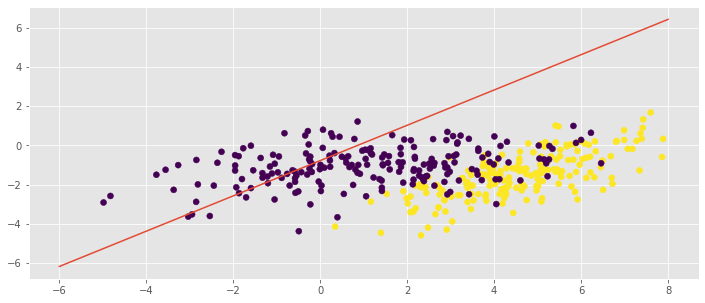

In [359]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

model = MySGDClassifier(batch_generator)
model.fit(X, y)
plot_decision_boundary(model)

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [360]:
from sklearn.datasets import make_classification

In [361]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [362]:
model_list_log = []
model_list_lin = []
alphas = [0.00001, 0.0001, 0.001, 0.01]
for alpha in alphas:
    print('alpha =', alpha)
    model_log = MySGDClassifier(batch_generator, C=1, alpha=alpha, max_epoch=10, model_type='log_reg')
    model_list_log.append(model_log.fit(X, y))
    model_lin = MySGDClassifier(batch_generator, C=1, alpha=alpha, max_epoch=10, model_type='lin_reg')
    model_list_lin.append(model_lin.fit(X, y))

alpha = 1e-05
alpha = 0.0001
alpha = 0.001
alpha = 0.01


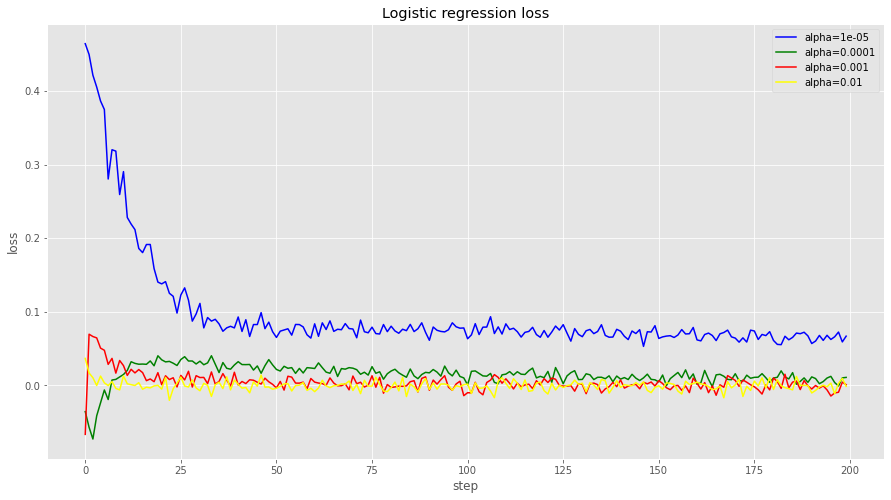

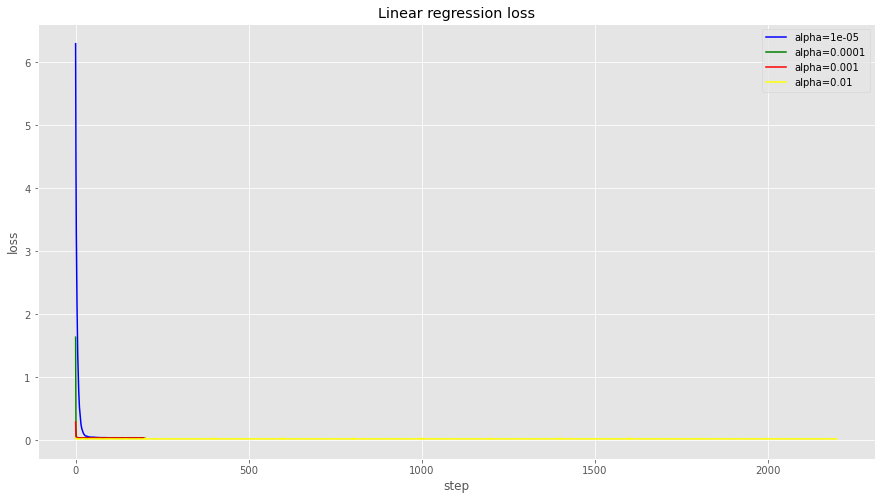

In [371]:
plt.figure(figsize=(15,8))
colors = ['blue', 'green', 'red', 'yellow']
for alpha, col, model in zip(alphas, colors, model_list_log):
    y_data = np.mean(np.asarray(model.errors_log['loss']).reshape((-1, 5000)), axis=1)
    x_data = [i for i in range(len(y_data))]
    plt.plot(x_data, y_data, color=col, label=f'alpha={alpha}')
plt.xlabel("step")
plt.legend()
plt.title('Logistic regression loss')
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(15,8))
for alpha, col, model in zip(alphas, colors, model_list_lin):
    y_data = np.mean(np.asarray(model.errors_log['loss']).reshape((-1, 5000)), axis=1)
    x_data = [i for i in range(len(y_data))]
    plt.plot(x_data, y_data, color=col, label=f'alpha={alpha}')
plt.xlabel("step")
plt.legend()
plt.title('Linear regression loss')
plt.ylabel("loss")
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?  
**Ответ:**   
При всех рассмотренных значениях alpha метод сходится, но с увеличением alpha это происходит быстрее, поэтому можно далее выбрать alpha=0.01.

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [366]:
## Your Code Here
C_values = np.logspace(3, -3, 10)
log_models = []
lin_models = []
for C in C_values:
    print('C =', C)
    model_log = MySGDClassifier(batch_generator, C=C, alpha=0.01, max_epoch=10, model_type='log_reg')
    model_log = model_log.fit(X, y)
    log_models.append(model_log)
    
    model_lin = MySGDClassifier(batch_generator, C=C, alpha=0.01, max_epoch=10, model_type='lin_reg')
    model_lin = model.fit(X, y)
    lin_models.append(model_lin)

C = 1000.0
C = 215.44346900318845
C = 46.4158883361278
C = 10.0
C = 2.1544346900318843
C = 0.4641588833612782
C = 0.1
C = 0.021544346900318867
C = 0.004641588833612782
C = 0.001


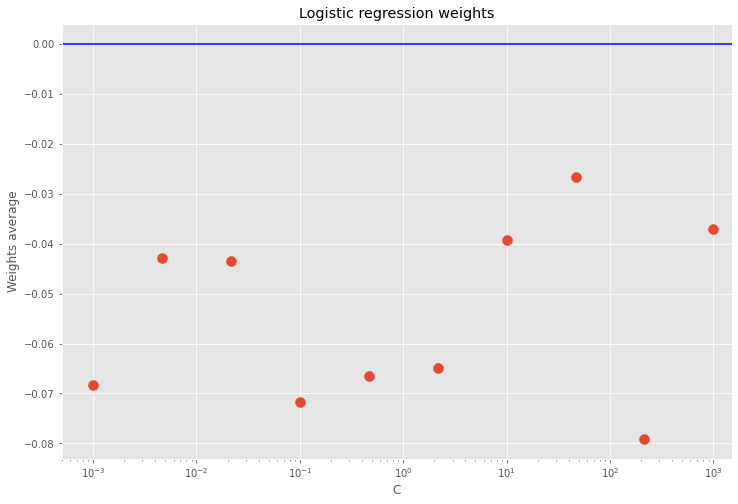

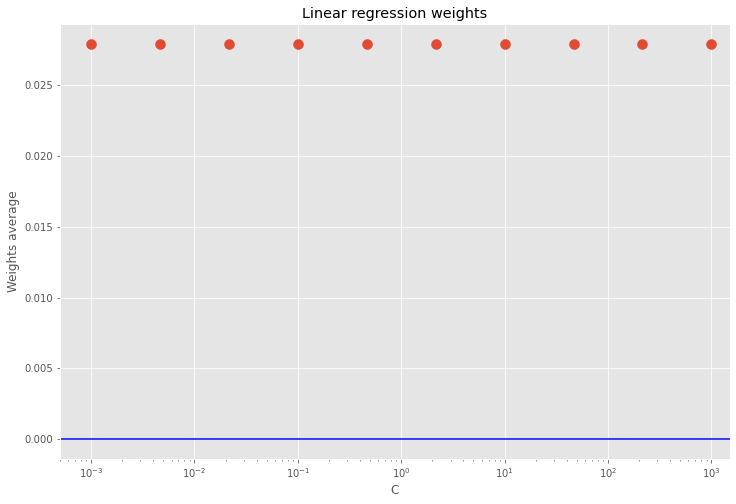

In [372]:
## Your Code Here
plt.figure(figsize=(12,8))
y_data = []
for model in log_models:
    y_data.append(np.mean(model.weights))
plt.scatter(C_values, y_data, s=100)
#plt.ylim([-1.3, 1.3])
plt.xlabel('C')
plt.xscale('log')
plt.xlim([0.0005, 1500])
plt.title('Logistic regression weights')
plt.ylabel("Weights average")
plt.hlines(0, 0, 1500, color = 'b')
plt.show()

plt.figure(figsize=(12,8))
y_data = []
for model in lin_models:
    y_data.append(np.mean(model.weights))
plt.scatter(C_values, y_data, s=100)
#plt.ylim([-1.3, 1.3])
plt.xlabel('C')
plt.xscale('log')
plt.xlim([0.0005, 1500])
plt.title('Linear regression weights')
plt.ylabel("Weights average")
plt.hlines(0, 0, 1500, color = 'b')
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса?  
**Ответ:** Для логистической регрессии в принципе есть из чего выбрать :) Лучше, чем просто использовать $C=1$, хотя и в таком случае веса были небольшие.  
Для линейной регрессии изменение вообще не значительное.

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [375]:
doc_to_title = {}
with open('docs_titles.tsv', encoding="utf8") as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [376]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [377]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15])
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


In [397]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [398]:
X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)
groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 15) (16627,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [395]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [436]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X = X_train.copy()
y = y.copy()
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

In [428]:
batch_sizes = [50, 500, 1000]
alphas = [0.0001, 0.001, 0.01]
max_epochs = [5, 15, 25, 35]
C_values = np.logspace(3, -3, 7)
model_types = ['lin_reg', 'log_red']
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

In [418]:
def get_predictions(y_hat, model_type, threshold=0.5):
    if model_type == 'lin_reg':
        mask = y_hat > 0
    elif model_type == 'log_reg':
        mask = y_hat > threshold
    return mask.astype(int)

In [419]:
params_lin = {'batch_generator':batch_generator, 'alpha':0.001, 'C': 10, 'model_type':'lin_reg', 'batch_size':1}
params_log = {'batch_generator':batch_generator, 'alpha':0.001, 'C': 10, 'model_type':'log_reg', 'batch_size':1}

In [420]:
f1_score_lin = []
f1_score_log = []
for batch_size in batch_sizes:
    print('batch_size =', batch_size)
    model_log = MySGDClassifier(batch_generator,
                                alpha=0.001,
                                model_type='log_reg',
                                batch_size=batch_size)
    model_lin = MySGDClassifier(batch_generator,
                                alpha=0.001,
                                model_type='lin_reg',
                                batch_size=batch_size)
    
    model_log.fit(X_train, y_train)
    y_pred_log = get_predictions(model_log.predict(X_val), model_type='log_reg')
    f1_score_log += [f1_score(y_val, y_pred_log)]

    model_lin.fit(X_train, y_train)
    y_pred_lin = get_predictions(model_lin.predict(X_val), model_type='lin_reg')
    f1_score_lin += [f1_score(y_val, y_pred_lin)]
        
params_log['batch_size'] = batch_sizes[np.argmax(f1_score_log)]
params_lin['batch_size'] = batch_sizes[np.argmax(f1_score_lin)]

batch_size = 50
batch_size = 500
batch_size = 1000


Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [422]:
f1_score_lin = []
f1_score_log = []
for C in C_values:
    print('C =', C)
    model_log = MySGDClassifier(batch_generator,
                                alpha=0.001,
                                C=C,
                                model_type='log_reg',
                                batch_size=params_log['batch_size'])
    model_lin = MySGDClassifier(batch_generator,
                                alpha=0.001,
                                C=C,
                                model_type='lin_reg',
                                batch_size=params_lin['batch_size'])
    
    model_log.fit(X_train, y_train)
    y_pred_log = get_predictions(model_log.predict(X_val), model_type='log_reg')
    f1_score_log += [f1_score(y_val, y_pred_log)]

    model_lin.fit(X_train, y_train)
    y_pred_lin = get_predictions(model_lin.predict(X_val), model_type='lin_reg')
    f1_score_lin += [f1_score(y_val, y_pred_lin)]
    
params_log['C'] = C_values[np.argmax(f1_score_log)]
params_lin['C'] = C_values[np.argmax(f1_score_lin)]

C = 1000.0
C = 100.0
C = 10.0
C = 1.0
C = 0.1
C = 0.01
C = 0.001


In [426]:
f1_score_lin = []
f1_score_log = []
for alpha in alphas:
    print('alpha =', alpha)
    model_log = MySGDClassifier(batch_generator,
                                alpha=alpha,
                                C=params_log['C'],
                                model_type='log_reg',
                                batch_size=params_log['batch_size'])
    model_lin = MySGDClassifier(batch_generator,
                                alpha=alpha,
                                C=params_lin['C'],
                                model_type='lin_reg',
                                batch_size=params_lin['batch_size'])
    
    model_log.fit(X_train, y_train)
    y_pred_log = get_predictions(model_log.predict(X_val), model_type='log_reg')
    f1_score_log += [f1_score(y_val, y_pred_log)]

    model_lin.fit(X_train, y_train)
    y_pred_lin = get_predictions(model_lin.predict(X_val), model_type='lin_reg')
    f1_score_lin += [f1_score(y_val, y_pred_lin)]
    
params_log['alpha'] = alphas[np.argmax(f1_score_log)]
params_lin['alpha'] = alphas[np.argmax(f1_score_lin)]

alpha = 0.0001
alpha = 0.001
alpha = 0.01


In [429]:
f1_score_lin = []
f1_score_log = []
for max_epoch in max_epochs:
    print('max_epoch =', max_epoch)
    model_log = MySGDClassifier(batch_generator,
                                alpha=params_log['alpha'],
                                C=params_log['C'],
                                model_type='log_reg',
                                batch_size=params_log['batch_size'])
    model_lin = MySGDClassifier(batch_generator,
                                alpha=params_lin['alpha'],
                                C=params_lin['C'],
                                model_type='lin_reg',
                                batch_size=params_lin['batch_size'])
    
    model_log.fit(X_train, y_train)
    y_pred_log = get_predictions(model_log.predict(X_val), model_type='log_reg')
    f1_score_log += [f1_score(y_val, y_pred_log)]

    model_lin.fit(X_train, y_train)
    y_pred_lin = get_predictions(model_lin.predict(X_val), model_type='lin_reg')
    f1_score_lin += [f1_score(y_val, y_pred_lin)]
    
params_log['max_epoch'] = max_epochs[np.argmax(f1_score_log)]
params_lin['max_epoch'] = max_epochs[np.argmax(f1_score_lin)]

max_epoch = 5
max_epoch = 15
max_epoch = 25
max_epoch = 35


In [430]:
params = dict()
if np.max(f1_score_log) > np.max(f1_score_lin):
    model_type = 'log_reg'
    params = params_log
else:
    model_type = 'lin_reg'
    params = params_lin

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [433]:
scores = []
for threshold in thresholds:
    model = MySGDClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = get_predictions(model.predict(X_val), threshold=threshold, model_type=model_type)
    scores += [f1_score(y_val, y_pred)]

best_threshold = thresholds[np.argmax(scores)]

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

In [437]:
model = MySGDClassifier(**params)
model.fit(X, y)
y_pred = get_predictions(model.predict(X_test), threshold=best_threshold, model_type=model_type)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 11 is different from 16)

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***